# Homophily Tutorial

In [ ]:
import rootutils

rootutils.setup_root("./", indicator=".project-root", pythonpath=True)

import torch
import hydra
from topobenchmark.data.loaders.graph import *
from topobenchmark.data.loaders.hypergraph import *
from topobenchmark.data.preprocessor import PreProcessor
from topobenchmark.utils.config_resolvers import (
    get_default_transform,
    get_monitor_metric,
    get_monitor_mode,
    infer_in_channels,
)
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

hydra.initialize(config_path="../configs", job_name="job")


# Group Homophily

### Loade the data and calculate the group homophily

In [2]:
cfg = hydra.compose(config_name="run.yaml", overrides=["model=hypergraph/unignn2", "dataset=hypergraph/coauthorship_cora"], return_hydra_config=True)
loader = hydra.utils.instantiate(cfg.dataset.loader)

dataset, dataset_dir = loader.load()

# Apply transform

transform_config = {"group_homophily" :
    {
    '_target_': 'topobenchmark.transforms.data_transform.DataTransform',
    'transform_name': 'GroupCombinatorialHomophily',
    'transform_type': 'data manipulation',
    'top_k': 5,
    }
}
processed_dataset = PreProcessor(dataset, dataset_dir, transform_config)
data = processed_dataset.data

Download complete.
Transform parameters are the same, using existing data_dir: /home/lev/projects/TopoBenchmark/datasets/hypergraph/coauthorship/coauthorship_cora/group_homophily/1048349801


Extracting /home/lev/projects/TopoBenchmark/datasets/hypergraph/coauthorship/coauthorship_cora/raw/coauthorship_cora.zip
/home/lev/miniconda3/envs/tb/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


### Define plotting function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

colors = np.array([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
    '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
    '#d6616b', '#d1e5f0', '#e7ba52', '#d6616b', '#ad494a',
    '#8c6d31', '#e7969c', '#7b4173', '#aec7e8', '#ff9896',
    '#98df8a', '#d62728', '#ffbb78', '#1f77b4', '#ff7f0e',
    '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf', '#c5b0d5', '#c49c94', '#f7b6d2',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
    '#d6616b', '#d1e5f0', '#e7ba52', '#d6616b', '#ad494a',
    '#8c6d31', '#e7969c', '#7b4173', '#aec7e8', '#ff9896',
    '#98df8a', '#d62728', '#ffbb78', '#1f77b4', '#ff7f0e',
    '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf', '#c5b0d5', '#c49c94', '#f7b6d2'
])  


def normalised_bias(D, B):
    out = torch.zeros(D.shape)
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if D[i,j] >= B[i,j]:
                out[i,j] = (D[i,j] - B[i,j]) / (1 - B[i,j])
            else:
                out[i,j] = (D[i,j] - B[i,j]) / B[i,j]
    return out


def make_plot(Dt, Bt, max_k, number_of_he, plot_type, ax, plot_tyitle=False):
    settings = {
      'font.family': 'serif',
      'text.latex.preamble': '\\renewcommand{\\rmdefault}{ptm}\\renewcommand{\\sfdefault}{phv}',
      'figure.figsize': (5.5, 3.399186938124422),
      'figure.constrained_layout.use': True,
      'figure.autolayout': False,
      'font.size': 16,
      'axes.labelsize': 24,
      'legend.fontsize': 24,
      'xtick.labelsize': 24,
      'ytick.labelsize': 24,
      'axes.titlesize': 24}
    with plt.rc_context(settings):
        if plot_type == 'normalised':
            h_t = normalised_bias(Dt, Bt)
        
        elif plot_type == 'affinity/baseline':
            h_t = Dt/Bt

        elif plot_type == 'affinity':
            h_t = Dt
            
        else:
            raise ValueError('plot_type must be one of: normalised, affinity/baseline, affinity')
        

        if max_k <= 20:    
        # Plot h_t lines with different colors corresponting to each row
            for i in range(h_t.shape[0]):
                ax.plot(h_t[i],  '-o', markersize=8, color=colors[i], linewidth=2)

        else:
            x_values_to_visualize = []
            # Visualise only non-zero values, x indices have to correspont to position of non zero values
            for i in range(h_t.shape[0]):
                # Get non-zero values
                if plot_type in ['affinity', 'affinity/baseline']:
                    non_zero = np.where(h_t[i, :] > 1e-6)[0]
                    #print(non_zero)
                elif plot_type == 'normalised': 
                    # do not take the ones which are equal to 0
                    
                    non_zero = np.where((h_t[i, :] > -0.99) & (h_t[i, :] != 0))[0]

                # Plot non-zero values and make sure when several values have same y value they are not plotted on top of each other
                ax.plot(non_zero + 1, h_t[i, non_zero], '-o', markersize=4, color=colors[i])

                # Add x values to the list of x values to visualise
                x_values_to_visualize.extend(list(set(list(non_zero + 1))))
        
        
        # Manually put axis x values and five size of the ticks
        if max_k <= 20:
            ax.set_xticks(range(h_t.shape[1]), [str(i) for i in range(1, h_t.shape[1]+1)])
        else:
            ax.set_xticks(x_values_to_visualize, [str(i) for i in x_values_to_visualize])
            
        # Size of the ticks
        ax.tick_params(axis='x', which='major')
    
        # Add title and labels
        if plot_tyitle:
            ax.set_title(f'{max_k}-uniform hypergraph, number of hyperedges: {number_of_he}')
        else:
            pass    
        # Add grid to the plot
        ax.grid()
        if plot_type == 'normalised':
            ax.set_ylabel('Normalised bias', fontsize=20)
            # Put a line perpendicular axis x in values 1, make it thin and black
            ax.axhline(y=0, color='k', linestyle='--', linewidth=2)
            # Make y scale be between 0 and 1
            ax.set_ylim(-1.1, 1.1)
            #plt.ylim(bottom=-1.2)

        elif plot_type == 'affinity/baseline':
            ax.set_ylabel('Affinity/Baseline', fontsize=20 )
            # Make y axis logarithmic with 10 as base
            # Make y axis logarithmic but manually
            ax.set_yscale('symlog')
            
            # Put a line perpendicular axis x in values 1, make it thin and black
            ax.axhline(y=1, color='k', linestyle='--', linewidth=2)
            ax.set_yticks([0, 1])
            ax.set_ylim(bottom=-0.5)

        elif plot_type == 'affinity':
            ax.set_ylabel('Affinity', fontsize=20)
            ax.set_ylim(-0.1, 1.1)
        else:
            raise ValueError('plot_type must be one of: normalised, affinity-t, affinity')
        ax.grid()
    return ax

### Plotting

/tmp/ipykernel_97245/14240756.py:24: UserWarning: The figure layout has changed to tight
  f.tight_layout()


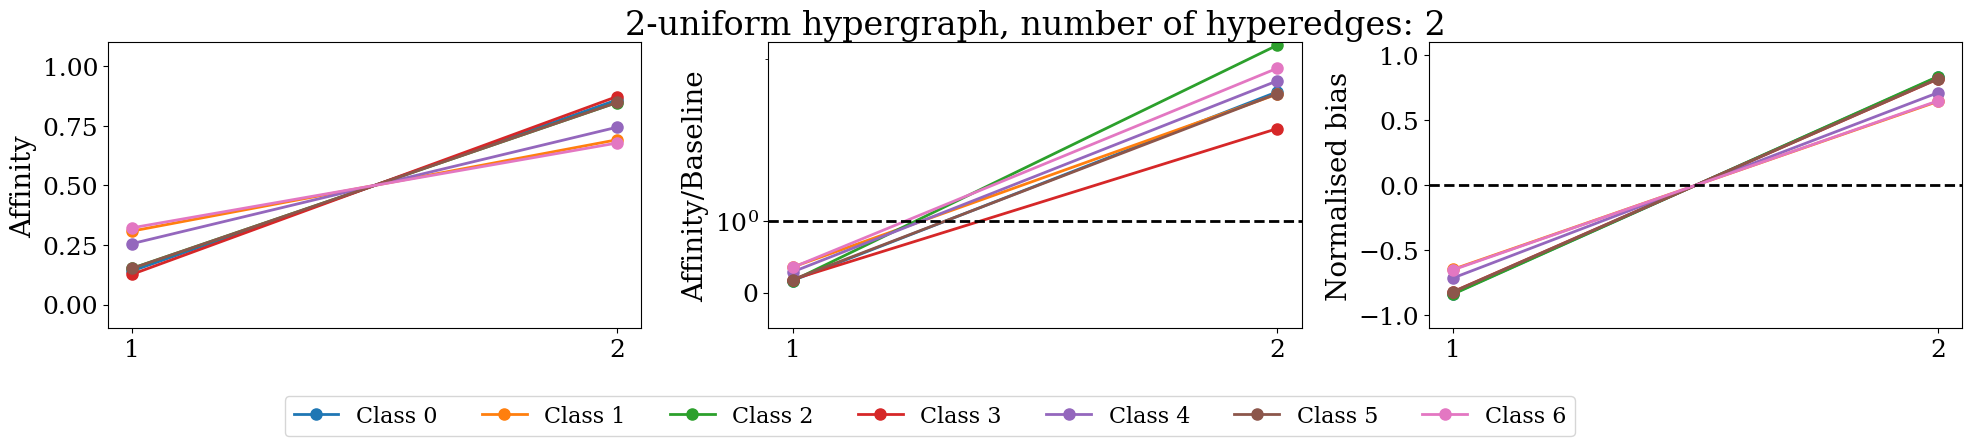

/tmp/ipykernel_97245/14240756.py:24: UserWarning: The figure layout has changed to tight
  f.tight_layout()


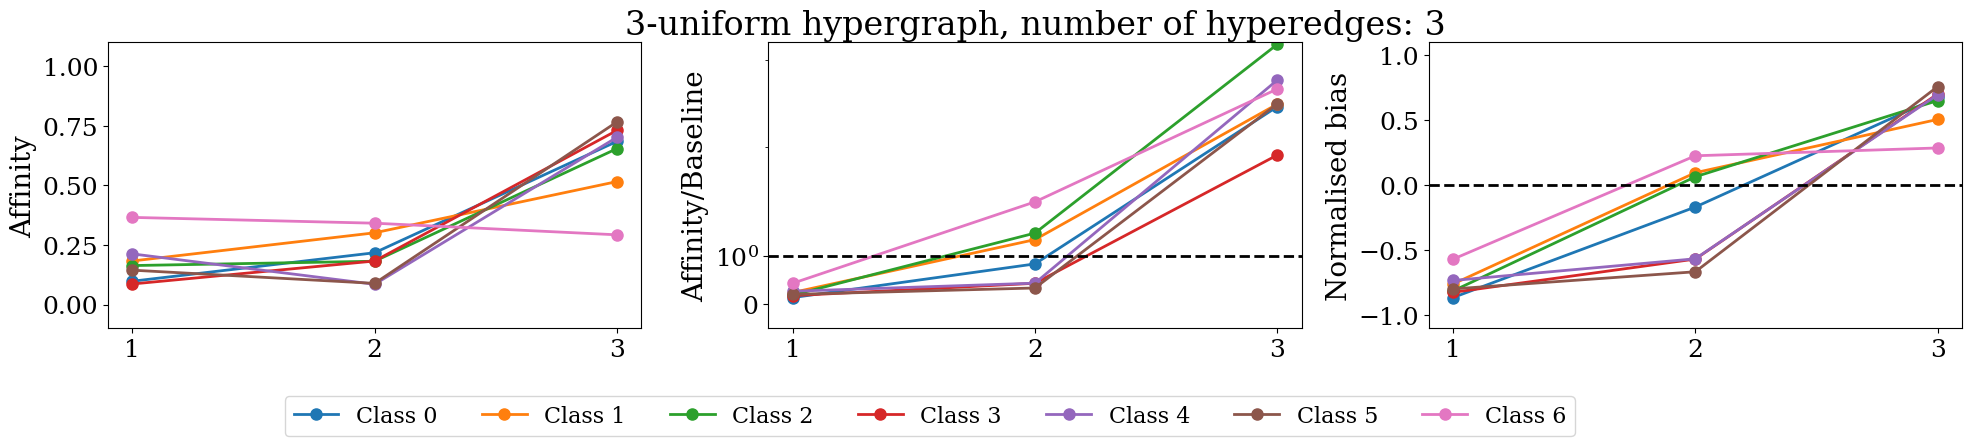

/tmp/ipykernel_97245/14240756.py:24: UserWarning: The figure layout has changed to tight
  f.tight_layout()


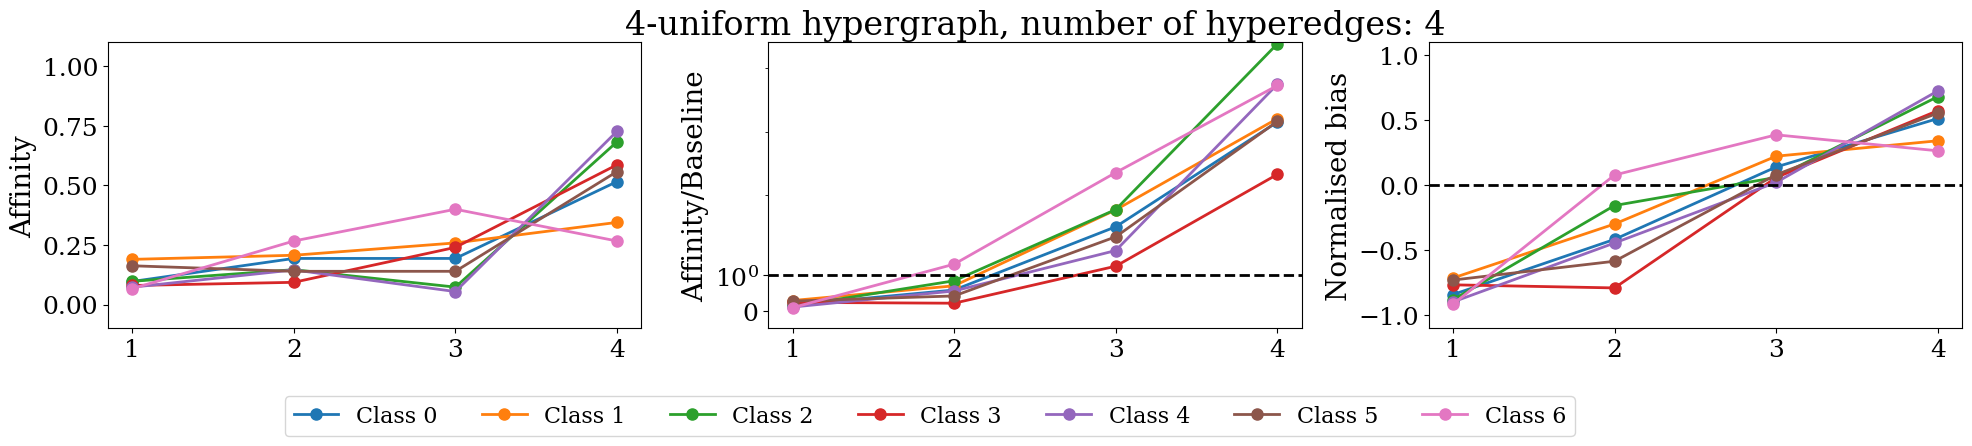

/tmp/ipykernel_97245/14240756.py:24: UserWarning: The figure layout has changed to tight
  f.tight_layout()


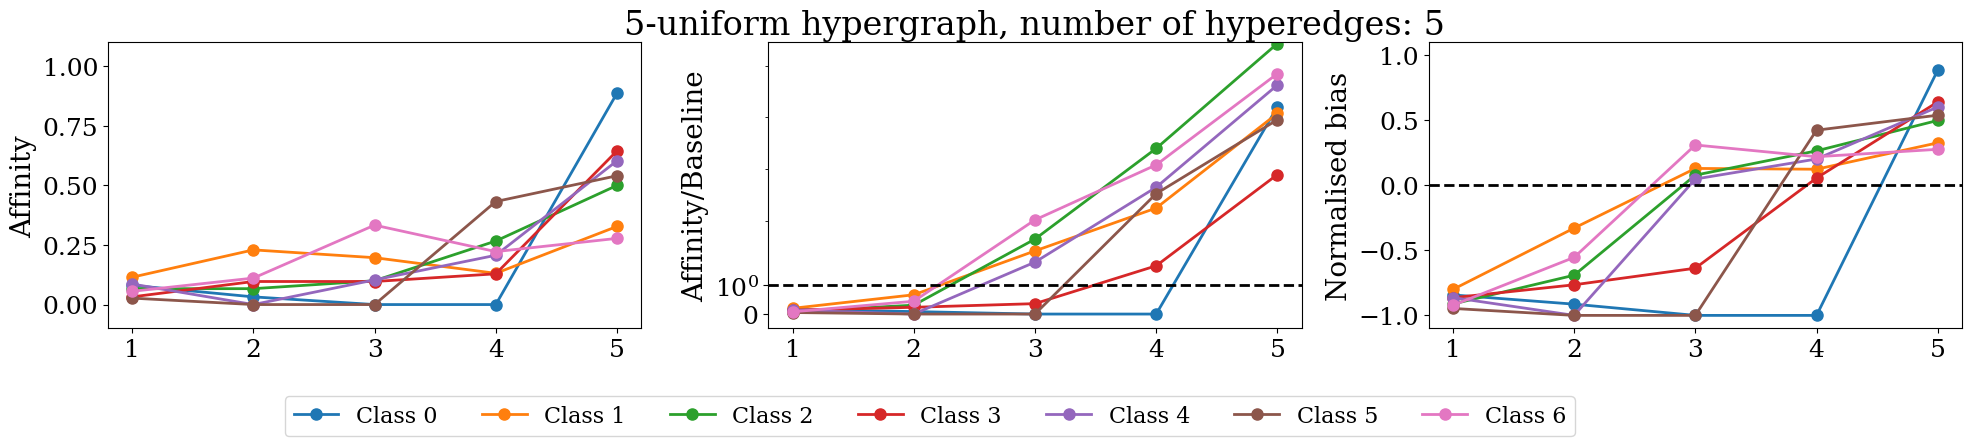

In [4]:
unique_labels = torch.unique(data.y).numpy()
figures = []
for key in data.group_combinatorial_homophily.keys():
    max_k = int(key.strip('he_card='))
    Dt, Bt, number_of_he = data.group_combinatorial_homophily[key]['Dt'], data.group_combinatorial_homophily[key]['Bt'], data.group_combinatorial_homophily[key]['num_hyperedges']

    settings = {
                'font.family': 'serif',
                'text.latex.preamble': '\\renewcommand{\\rmdefault}{ptm}\\renewcommand{\\sfdefault}{phv}',
                'figure.figsize': (20, 4),
                'figure.constrained_layout.use': True,
                'figure.autolayout': False,
                'font.size': 16,
                'axes.labelsize': 18,
                'legend.fontsize': 24,
                'xtick.labelsize': 18,
                'ytick.labelsize': 18,
                'axes.titlesize': 18}
    with plt.rc_context(settings):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3)
        figures.append(make_plot(Dt, Bt, max_k, max_k, ax=ax1, plot_type='affinity'))
        figures.append(make_plot(Dt, Bt, max_k, max_k, ax=ax2, plot_type='affinity/baseline', plot_tyitle=True))
        figures.append(make_plot(Dt, Bt, max_k, max_k, ax=ax3, plot_type='normalised'))
        f.tight_layout()

        if Dt.shape[0]>4 and Dt.shape[0]<= 20:
            f.legend(['Class {}'.format(i) for i in range(len(unique_labels))], fontsize=16,
                    ncol=Dt.shape[0], 
                    bbox_to_anchor=(0.8, .0))
        
        
        elif len(unique_labels)> 20:
            pass
        else:
            f.legend(['Class {}'.format(i) for i in range(len(unique_labels))], fontsize=16,
                    ncol=Dt.shape[0], 
                    bbox_to_anchor=(0.65, .0))
        plt.show()


# Message-Passing Homophily

In [5]:
cfg = hydra.compose(config_name="run.yaml", overrides=["model=hypergraph/unignn2","dataset=hypergraph/coauthorship_cora"], return_hydra_config=True)
loader = hydra.utils.instantiate(cfg.dataset.loader)
dataset, dataset_dir = loader.load()

data = dataset.data

# Create transform config
transform_config = {"mp_homophily" :
    {
    '_target_': 'topobenchmark.transforms.data_transform.DataTransform',
    'transform_name': 'MessagePassingHomophily',
    'transform_type': 'data manipulation',
    'num_steps': 3,
    'incidence_field': "incidence_hyperedges",
    }
}

# Apply transform
processed_dataset = PreProcessor(dataset, dataset_dir, transform_config)
data = processed_dataset.data

Download complete.
Transform parameters are the same, using existing data_dir: /home/lev/projects/TopoBenchmark/datasets/hypergraph/coauthorship/coauthorship_cora/mp_homophily/2005719047


Extracting /home/lev/projects/TopoBenchmark/datasets/hypergraph/coauthorship/coauthorship_cora/raw/coauthorship_cora.zip
/home/lev/miniconda3/envs/tb/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


### Plotting

In [6]:
def plot_homophily_scatter(avr_class_type1, labels, non_isolated_nodes, type1, step, save_to=None):
  

    colors = np.array([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
    '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
    '#d6616b', '#d1e5f0', '#e7ba52', '#d6616b', '#ad494a',
    '#8c6d31', '#e7969c', '#7b4173', '#aec7e8', '#ff9896',
    '#98df8a', '#d62728', '#ffbb78', '#1f77b4', '#ff7f0e',
    '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf', '#c5b0d5', '#c49c94', '#f7b6d2',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
    '#d6616b', '#d1e5f0', '#e7ba52', '#d6616b', '#ad494a',
    '#8c6d31', '#e7969c', '#7b4173', '#aec7e8', '#ff9896',
    '#98df8a', '#d62728', '#ffbb78', '#1f77b4', '#ff7f0e',
    '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf', '#c5b0d5', '#c49c94', '#f7b6d2'
])  
    right_shift_points = 0

    
    shift = int(np.mean(np.unique(labels[non_isolated_nodes], return_counts=True)[1]) * 0.1) #+ int(np.std(np.unique(labels, return_counts=True)[1]) * 0.1)
    
    plt.figure(figsize=(10, 6))

    for i in range(len(avr_class_type1)):
        x_left = np.where(labels[non_isolated_nodes] == i)[0][0] + right_shift_points
        x_right = np.where(labels[non_isolated_nodes] == i)[0][-1] + right_shift_points
        plt.plot([x_left, x_right],
                 [avr_class_type1[i], avr_class_type1[i]],
                 color=colors[i],
                 linewidth=2)

        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        plt.vlines(x=[x_left, x_right],
                   ymin=[avr_class_type1[i]-0.01, avr_class_type1[i]-0.01],
                   ymax=[avr_class_type1[i]+0.01, avr_class_type1[i]+0.01],
                   colors=colors[i], ls='-', lw=1)
        
        if len(np.unique(labels)) < 20:
            text_fontsize = 20
        else:
            text_fontsize = 10
            
        plt.text(x_left + (x_right - x_left)/2,
                 avr_class_type1[i] + 0.03,
                 np.where(labels[non_isolated_nodes] == i)[0].shape[0],
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='black', weight='bold',
                 fontsize=text_fontsize)
    
        right_shift_points += shift

    # if len(np.unique(labels))< 20:
    #     leg = [mlines.Line2D([], [], color=colors[i], label=f'Class {i}') for i in range(len(avr_class_type1))]

    #     plt.legend(handles=leg, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol=len(avr_class_type1), fontsize=10)

    right_shift_points = 0

    
    x = np.arange(len(type1))
    for i in range(len(avr_class_type1)):
        plt.scatter(x[np.where(labels[non_isolated_nodes] == i)[0]] + right_shift_points, type1[np.where(labels[non_isolated_nodes] == i)[0]],
                    c=colors[i], s=10, marker='+', alpha=.75, label=f'Class {i}')

        
        
        most_right_point = x[np.where(labels[non_isolated_nodes] == i)[0]][-1] + right_shift_points
        plt.scatter([most_right_point] * shift + np.arange(shift), [1]*shift,
                    c=colors[i], s=10, marker='+', alpha=.0)
        
        
        right_shift_points += shift

    
    if step>0:
        # get rid of y ticks
        plt.yticks(np.arange(0, 1.05, 0.1), alpha=0.0)
        plt.ylim(0, 1.05)

    else:
        plt.ylabel('Homophily', fontsize=28)
        plt.yticks(np.arange(0, 1.05, 0.1))
        plt.ylim(0, 1.05)
    plt.grid(axis='x', color='white', linestyle='-')


    if save_to is not None:
        plt.savefig(save_to, dpi=600)
    fig = plt.gcf()
    plt.close()

    return fig


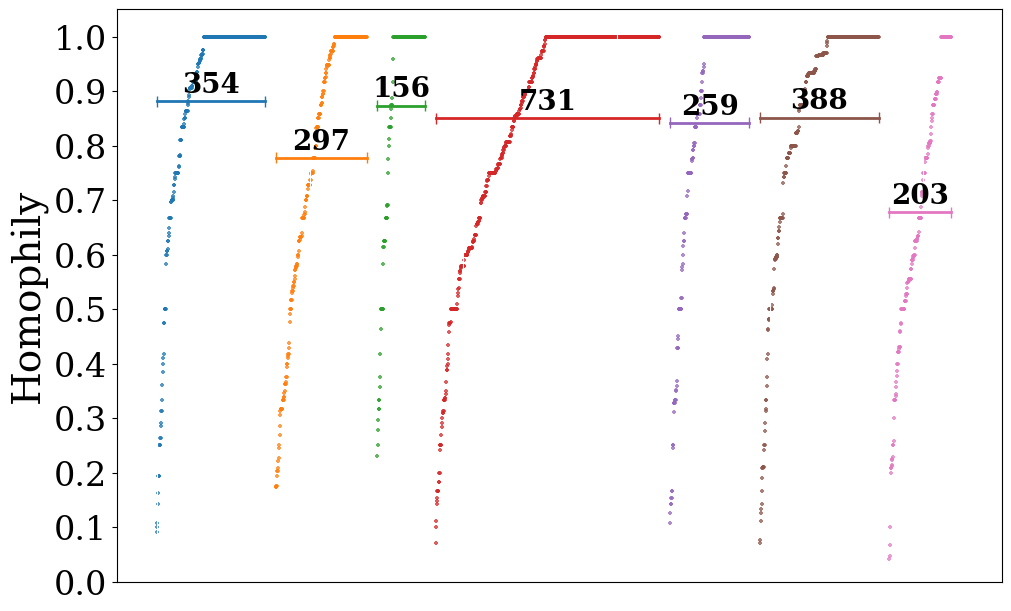

In [7]:

H = data.incidence_hyperedges.to_dense().numpy()
labels = data.y.numpy()
n_steps=11
Ep, Np = data['mp_homophily']['Ep'].numpy(), data['mp_homophily']['Np'].numpy()
num_steps = transform_config['mp_homophily']['num_steps']


isolated_nodes = np.where(H.sum(0) == 1)[0]
# Get non-isolated nodes
non_isolated_nodes = np.array(list(set(np.arange(H.shape[0])) - set(isolated_nodes)))

# Sort non-isolated nodes by their class node
non_isolated_nodes = non_isolated_nodes[np.argsort(labels[non_isolated_nodes])]

# Extract the class node probability distribution for non-isolated nodes
sorted_labels = labels[non_isolated_nodes]
avr_class_homophily_types = []
types = []
for step in range(num_steps):
    type = Np[step, non_isolated_nodes, sorted_labels]

    # Within every class, sort the nodes by their class node probability distribution
    avr_class_type = []
    
    for i in np.unique(sorted_labels):
        idx = np.where(sorted_labels == i)[0]
        type[idx] = type[idx][np.argsort(type[idx])]
        avr_class_type.append(np.mean(type[idx]))
    
    avr_class_homophily_types.append(avr_class_type)
    types.append(type)


settings = {
      'font.family': 'serif',
      'text.latex.preamble': '\\renewcommand{\\rmdefault}{ptm}\\renewcommand{\\sfdefault}{phv}',
      'figure.figsize': (5.5, 3.399186938124422),
      'figure.constrained_layout.use': True,
      'figure.autolayout': False,
      'font.size': 16,
      'axes.labelsize': 24,
      'legend.fontsize': 24,
      'xtick.labelsize': 24,
      'ytick.labelsize': 24,
      'axes.titlesize': 24}

step = 0 

with plt.rc_context(settings):
    fig = plot_homophily_scatter(avr_class_homophily_types[step], data.y, non_isolated_nodes, types[step], step=step, save_to=None)
    plt.close()
fig


# MP Homophily for cell-complex

In [8]:
from omegaconf import OmegaConf, open_dict
# Recompose config with additional override of model equivalent to ""model=cell/cwn"" which will force to load approriate tranforms
cfg = hydra.compose(config_name="run.yaml", overrides=["dataset=graph/cocitation_cora", "model=cell/cwn"], return_hydra_config=True)
loader = hydra.utils.instantiate(cfg.dataset.loader)
dataset, dataset_dir = loader.load()

data = dataset.data

# Create transform config

# Add one more transform into Omegaconf dict

new_transform = {
    '_target_': 'topobenchmark.transforms.data_transform.DataTransform',
    'transform_name': 'MessagePassingHomophily',
    'transform_type': 'data manipulation',
    'num_steps': 3,
    'incidence_field': "incidence_1",
    }
# Use open_dict to temporarily disable struct mode
with open_dict(cfg.transforms):
    cfg.transforms["mp_homophily"] = OmegaConf.create(new_transform)

# Apply transform
processed_dataset = PreProcessor(dataset, dataset_dir, cfg.transforms)
data = processed_dataset.data



Transform parameters are the same, using existing data_dir: /home/lev/projects/TopoBenchmark/datasets/graph/cocitation/Cora/graph2cell_lifting_mp_homophily/1963906553


/home/lev/miniconda3/envs/tb/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


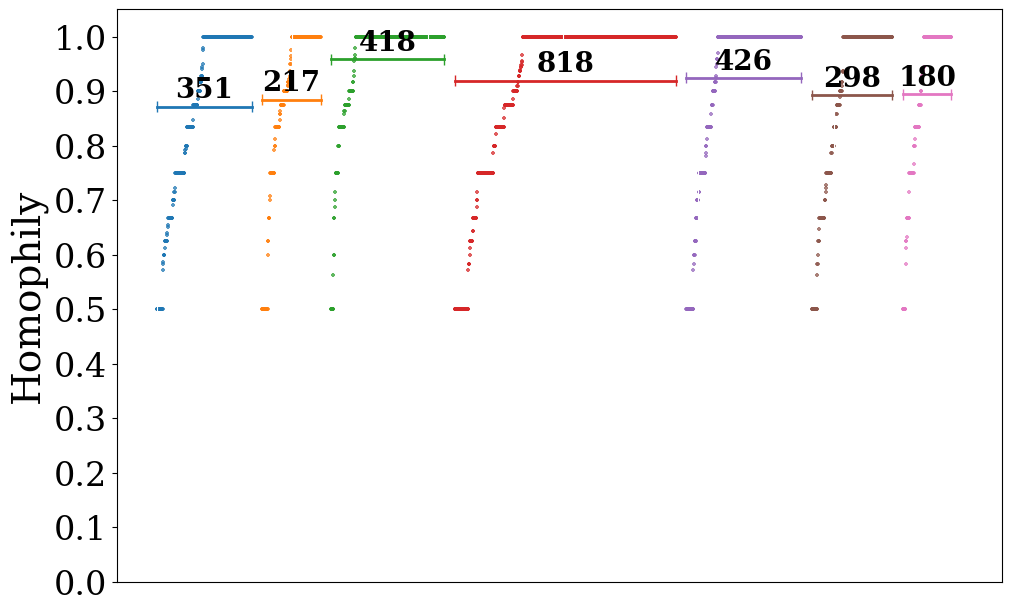

In [9]:
H = data.incidence_1.to_dense().numpy()
labels = data.y.numpy()
n_steps=11
Ep, Np = data['mp_homophily']['Ep'].numpy(), data['mp_homophily']['Np'].numpy()
num_steps = transform_config['mp_homophily']['num_steps']


isolated_nodes = np.where(H.sum(0) == 1)[0]
# Get non-isolated nodes
non_isolated_nodes = np.array(list(set(np.arange(H.shape[0])) - set(isolated_nodes)))

# Sort non-isolated nodes by their class node
non_isolated_nodes = non_isolated_nodes[np.argsort(labels[non_isolated_nodes])]

# Extract the class node probability distribution for non-isolated nodes
sorted_labels = labels[non_isolated_nodes]
avr_class_homophily_types = []
types = []
for step in range(num_steps):
    type = Np[step, non_isolated_nodes, sorted_labels]

    # Within every class, sort the nodes by their class node probability distribution
    avr_class_type = []
    
    for i in np.unique(sorted_labels):
        idx = np.where(sorted_labels == i)[0]
        type[idx] = type[idx][np.argsort(type[idx])]
        avr_class_type.append(np.mean(type[idx]))
    
    avr_class_homophily_types.append(avr_class_type)
    types.append(type)


settings = {
      'font.family': 'serif',
      'text.latex.preamble': '\\renewcommand{\\rmdefault}{ptm}\\renewcommand{\\sfdefault}{phv}',
      'figure.figsize': (5.5, 3.399186938124422),
      'figure.constrained_layout.use': True,
      'figure.autolayout': False,
      'font.size': 16,
      'axes.labelsize': 24,
      'legend.fontsize': 24,
      'xtick.labelsize': 24,
      'ytick.labelsize': 24,
      'axes.titlesize': 24}

step = 0 

with plt.rc_context(settings):
    fig = plot_homophily_scatter(avr_class_homophily_types[step], data.y, non_isolated_nodes, types[step], step=step, save_to=None)
    plt.close()
fig


### Hypergraph

In [10]:
from omegaconf import OmegaConf, open_dict
# Recompose config with additional override of model equivalent to ""model=hypergraph/unignn2"" which will force to load approriate tranforms
cfg = hydra.compose(config_name="run.yaml", overrides=["dataset=graph/cocitation_cora", "model=hypergraph/unignn2"], return_hydra_config=True)
loader = hydra.utils.instantiate(cfg.dataset.loader)
dataset, dataset_dir = loader.load()

data = dataset.data

# Create transform config

# Add one more transform into Omegaconf dict

new_transform = {
    '_target_': 'topobenchmark.transforms.data_transform.DataTransform',
    'transform_name': 'MessagePassingHomophily',
    'transform_type': 'data manipulation',
    'num_steps': 3,
    'incidence_field': "incidence_hyperedges",
    }

# Use open_dict to temporarily disable struct mode
with open_dict(cfg.transforms):
    cfg.transforms["mp_homophily"] = OmegaConf.create(new_transform)

# # Apply transform
processed_dataset = PreProcessor(dataset, dataset_dir, cfg.transforms)
data = processed_dataset.data



Transform parameters are the same, using existing data_dir: /home/lev/projects/TopoBenchmark/datasets/graph/cocitation/Cora/graph2hypergraph_lifting_mp_homophily/1975368801


/home/lev/miniconda3/envs/tb/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [11]:
H = data.incidence_hyperedges.to_dense().numpy()
labels = data.y.numpy()
n_steps=11
Ep, Np = data['mp_homophily']['Ep'].numpy(), data['mp_homophily']['Np'].numpy()
num_steps = transform_config['mp_homophily']['num_steps']


isolated_nodes = np.where(H.sum(0) == 1)[0]
# Get non-isolated nodes
non_isolated_nodes = np.array(list(set(np.arange(H.shape[0])) - set(isolated_nodes)))

# Sort non-isolated nodes by their class node
non_isolated_nodes = non_isolated_nodes[np.argsort(labels[non_isolated_nodes])]

# Extract the class node probability distribution for non-isolated nodes
sorted_labels = labels[non_isolated_nodes]
avr_class_homophily_types = []
types = []
for step in range(num_steps):
    type = Np[step, non_isolated_nodes, sorted_labels]

    # Within every class, sort the nodes by their class node probability distribution
    avr_class_type = []
    
    for i in np.unique(sorted_labels):
        idx = np.where(sorted_labels == i)[0]
        type[idx] = type[idx][np.argsort(type[idx])]
        avr_class_type.append(np.mean(type[idx]))
    
    avr_class_homophily_types.append(avr_class_type)
    types.append(type)


settings = {
      'font.family': 'serif',
      'text.latex.preamble': '\\renewcommand{\\rmdefault}{ptm}\\renewcommand{\\sfdefault}{phv}',
      'figure.figsize': (5.5, 3.399186938124422),
      'figure.constrained_layout.use': True,
      'figure.autolayout': False,
      'font.size': 16,
      'axes.labelsize': 24,
      'legend.fontsize': 24,
      'xtick.labelsize': 24,
      'ytick.labelsize': 24,
      'axes.titlesize': 24}

step = 0 

with plt.rc_context(settings):
    fig = plot_homophily_scatter(avr_class_homophily_types[step], data.y, non_isolated_nodes, types[step], step=step, save_to=None)
    plt.close()
fig